# Deteccion de caracteres con TF y keras

## Importo Librerias

In [1]:
#Importo librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import cv2
import random
from PIL import Image, ImageFilter
#from google.colab.patches import cv2_imshow
from IPython.display import Image as ImageDisplay
from IPython.core.display import HTML
from io import BytesIO
import base64
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Funciones auxiliares

In [2]:
# Funciones auxiliares
def np_to_base64_img(arr):
    """Convierte un np.array a una imagen embebida en base64"""
    h,w = arr.shape[:2]
    im = Image.fromarray(arr)
    buffer = BytesIO()
    im.save(buffer, format="PNG")
    img_str = base64.b64encode(buffer.getvalue()).decode()
    return f'<img src="data:image/png;base64,{img_str}" width="{w}" height="{h}"/>'

In [3]:
def get_bbox_from_image(image_array):
    """
    Toma un array NumPy de una imagen en escala de grises, encuentra los contornos,
    los combina y devuelve las coordenadas de la bounding box en formato
    (x_min, y_min, x_max, y_max).

    Args:
        image_array (np.ndarray): Una imagen en escala de grises como un array NumPy.

    Returns:
        tuple: Una tupla (x_min, y_min, x_max, y_max) que representa la bounding box.
               Retorna None si no se encuentran contornos.
    """
    # Asegurarse de que la imagen esté en escala de grises si no lo está ya
    if len(image_array.shape) == 3:
        gray_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image_array

    # Binarizar la imagen si es necesario para asegurar buenos contornos
    # Esto es crucial si la imagen de entrada tiene tonos de gris en lugar de solo blanco/negro
    # Ajusta el umbral (e.g., 127) y el tipo (e.g., cv2.THRESH_BINARY_INV) según tus imágenes.
    _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


    # Encontrar contornos
    # cv2.RETR_EXTERNAL recupera solo los contornos externos (útil para caracteres con agujeros internos)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        binary_image=cv2.bitwise_not(binary_image)
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return None # No se encontraron contornos

    # Combinar todos los contornos en uno solo (para caracteres con múltiples partes como 'i' o 'j')
    # Solo apilamos si hay contornos válidos (size > 0)
    valid_contours = [c.squeeze() for c in contours if c.size > 0]
    if not valid_contours:
        return None # No se encontraron contornos válidos después de limpiar

    all_points = np.vstack(valid_contours)

    # Encontrar el rectángulo delimitador para el contorno combinado
    x, y, w, h = cv2.boundingRect(all_points)

    # Retornar en el formato (x_min, y_min, x_max, y_max)
    x_min, y_min = x, y
    x_max, y_max = x + w, y + h

    return (x_min, y_min, x_max, y_max)

## Carga del dataset

In [4]:
# Cargar los datos del archivo npz
data = np.load(fr"C:\Users\Andres\Downloads\unified_dataset.npz", allow_pickle=True)

print(format(data))
images = data['images']
bboxes = data['bboxes']

# Crear un DataFrame de pandas
df = pd.DataFrame({'image': list(images), 'bbox':list(bboxes)})

# Aplicar la función np_to_base64_img a la columna 'image'
df['imagen_base64'] = df['image'].apply(np_to_base64_img)
df['bbox'] = df['image'].apply(get_bbox_from_image)

# Mostrar las primeras filas del nuevo DataFrame
print(df.head())

NpzFile 'C:\\Users\\Andres\\Downloads\\unified_dataset.npz' with keys: images, bboxes
                                               image            bbox  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  (5, 1, 25, 30)   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  (7, 1, 25, 30)   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  (7, 1, 24, 30)   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  (6, 1, 26, 31)   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  (8, 1, 23, 29)   

                                       imagen_base64  
0  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
1  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
2  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
3  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
4  <img src="data:image/png;base64,iVBORw0KGgoAAA...  


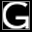

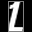

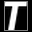

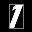

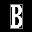

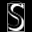

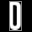

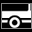

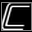

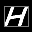

In [6]:
muestra = df.sample(10)
for index, row in muestra.iterrows():
  image = row['image']
  bbox = row['bbox']
  cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (128), 1)
  cv2_imshow(image)
  print("\n")

## Funciones de transformación para agumentado de datos

In [5]:
# --- Funciones auxiliares para transformar bounding boxes ---

def get_corners_from_bbox(bbox):
    """Convierte (x_min, y_min, x_max, y_max) a 4 puntos de esquina."""
    x_min, y_min, x_max, y_max = bbox
    return np.array([
        [x_min, y_min],
        [x_max, y_min],
        [x_max, y_max],
        [x_min, y_max]
    ], dtype=np.float32)

def get_bbox_from_corners(corners, image_shape):
    """
    Calcula la nueva bbox (x_min, y_min, x_max, y_max) a partir de 4 puntos de esquina transformados,
    asegurándose de que la bbox esté dentro de los límites de la imagen.
    """
    height, width = image_shape[:2]

    x_coords = corners[:, 0]
    y_coords = corners[:, 1]

    x_min = np.min(x_coords)
    y_min = np.min(y_coords)
    x_max = np.max(x_coords)
    y_max = np.max(y_coords)

    # Asegurarse de que las coordenadas estén dentro de los límites de la imagen
    x_min = max(0, int(x_min))
    y_min = max(0, int(y_min))
    x_max = min(width - 1, int(x_max))
    y_max = min(height - 1, int(y_max))

    # Asegurarse de que la caja sea válida (x_max >= x_min, y_max >= y_min)
    if x_max < x_min: x_max = x_min
    if y_max < y_min: y_max = y_min

    return (x_min, y_min, x_max, y_max)

# --- Funciones de Rotación, Escala y Perspectiva Modificadas ---

# Rotación
def rotar_imagen(imagen_np_array, bbox, angulo_rotacion_min, angulo_rotacion_max):
    """
    Rota una imagen y su bounding box asociada.
    La imagen de entrada debe ser un NumPy array.
    La bbox de entrada es (x_min, y_min, x_max, y_max).
    Devuelve la imagen rotada (NumPy array) y la nueva bbox.
    """
    img = Image.fromarray(imagen_np_array)
    ancho_original, alto_original = img.size

    # Aplico una rotación aleatoria dentro del rango permitido
    angulos_rotacion_opciones = [0, 0, random.uniform(angulo_rotacion_min, angulo_rotacion_max)]
    angulo_rotacion = random.choice(angulos_rotacion_opciones)

    # Rota la imagen, expandiendo el lienzo para que no se corte
    imagen_rotada_pil = img.rotate(angulo_rotacion, resample=Image.Resampling.BILINEAR, expand=True)
    imagen_rotada_np = np.array(imagen_rotada_pil)

    # Calcular la matriz de rotación para los puntos de la bbox
    # El centro de rotación cambia si expandimos la imagen
    ancho_nuevo, alto_nuevo = imagen_rotada_pil.size
    # Desplazamiento del centro (el centro de la imagen original se mueve al nuevo centro)
    dx = (ancho_nuevo - ancho_original) / 2
    dy = (alto_nuevo - alto_original) / 2

    # Matriz de rotación con traslación para el centro original
    M_rot = cv2.getRotationMatrix2D((ancho_original / 2, alto_original / 2), angulo_rotacion, 1.0)
    # Aplicar el desplazamiento para el nuevo tamaño de lienzo
    M_rot[0, 2] += dx
    M_rot[1, 2] += dy

    # Transformar las esquinas de la bbox
    bbox_corners = get_corners_from_bbox(bbox)
    # cv2.transform necesita los puntos en formato [N, 1, 2]
    transformed_corners = cv2.transform(bbox_corners.reshape(-1, 1, 2), M_rot).reshape(-1, 2)

    # Calcular la nueva bbox a partir de las esquinas transformadas
    nueva_bbox = get_bbox_from_corners(transformed_corners, imagen_rotada_np.shape)

    return imagen_rotada_np, nueva_bbox

# Perspectiva Vertical
def aplicar_perspectiva_vertical(imagen_np_array, bbox, factor, top=True):
    """
    Aplica una transformación de perspectiva vertical a una imagen y su bounding box.
    La imagen de entrada debe ser un NumPy array (BGR o escala de grises).
    La bbox de entrada es (x_min, y_min, x_max, y_max).
    Devuelve la imagen con perspectiva y la nueva bbox.
    """
    height, width = imagen_np_array.shape[:2]

    # Puntos originales de la imagen (esquinas)
    pts1_img = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])

    # Puntos de destino para la imagen
    pts2_img = np.copy(pts1_img)

    if 0 <= factor <= 1:
        if top:
            new_top_left_x = int(width * (1 - factor) / 2)
            new_top_right_x = width - 1 - new_top_left_x
            pts2_img[0] = [new_top_left_x, 0]
            pts2_img[1] = [new_top_right_x, 0]
        else:
            new_bottom_left_x = int(width * (1 - factor) / 2)
            new_bottom_right_x = width - 1 - new_bottom_left_x
            pts2_img[2] = [new_bottom_right_x, height - 1]
            pts2_img[3] = [new_bottom_left_x, height - 1]
    else:
        print("Advertencia: El factor de perspectiva debe estar entre 0 y 1. No se aplicó la transformación.")
        return imagen_np_array, bbox

    # Obtener la matriz de transformación de perspectiva
    M_perspectiva = cv2.getPerspectiveTransform(pts1_img, pts2_img)

    # Aplicar la transformación de perspectiva a la imagen
    imagen_con_perspectiva = cv2.warpPerspective(imagen_np_array, M_perspectiva, (width, height))

    # Transformar las esquinas de la bbox usando la misma matriz
    bbox_corners = get_corners_from_bbox(bbox)
    transformed_corners = cv2.perspectiveTransform(bbox_corners.reshape(-1, 1, 2), M_perspectiva).reshape(-1, 2)

    # Calcular la nueva bbox a partir de las esquinas transformadas
    nueva_bbox = get_bbox_from_corners(transformed_corners, imagen_con_perspectiva.shape)

    return imagen_con_perspectiva, nueva_bbox

# Perspectiva Horizontal
def aplicar_perspectiva_horizontal(imagen_np_array, bbox, factor, left=True):
    """
    Aplica una transformación de perspectiva horizontal a una imagen y su bounding box.
    La imagen de entrada debe ser un NumPy array (BGR o escala de grises).
    La bbox de entrada es (x_min, y_min, x_max, y_max).
    Devuelve la imagen con perspectiva y la nueva bbox.
    """
    height, width = imagen_np_array.shape[:2]

    # Puntos originales de la imagen (esquinas)
    pts1_img = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])

    # Puntos de destino para la imagen
    pts2_img = np.copy(pts1_img)

    if 0 <= factor <= 1:
        if left:
            new_top_left_y = int(height * (1 - factor) / 2)
            new_bottom_left_y = height - 1 - new_top_left_y
            pts2_img[0] = [0, new_top_left_y]
            pts2_img[3] = [0, new_bottom_left_y]
        else:
            new_top_right_y = int(height * (1 - factor) / 2)
            new_bottom_right_y = height - 1 - new_top_right_y
            pts2_img[1] = [width - 1, new_top_right_y]
            pts2_img[2] = [width - 1, new_bottom_right_y]
    else:
        print("Advertencia: El factor de perspectiva debe estar entre 0 y 1. No se aplicó la transformación.")
        return imagen_np_array, bbox

    # Obtener la matriz de transformación de perspectiva
    M_perspectiva = cv2.getPerspectiveTransform(pts1_img, pts2_img)

    # Aplicar la transformación de perspectiva a la imagen
    imagen_con_perspectiva = cv2.warpPerspective(imagen_np_array, M_perspectiva, (width, height))

    # Transformar las esquinas de la bbox usando la misma matriz
    bbox_corners = get_corners_from_bbox(bbox)
    transformed_corners = cv2.perspectiveTransform(bbox_corners.reshape(-1, 1, 2), M_perspectiva).reshape(-1, 2)

    # Calcular la nueva bbox a partir de las esquinas transformadas
    nueva_bbox = get_bbox_from_corners(transformed_corners, imagen_con_perspectiva.shape)

    return imagen_con_perspectiva, nueva_bbox


In [6]:
# prompt: quiero una funcion que rescale la imagen a 32x32 si fuera mas grande la imagen y ajuste el bbox a ese tamaño en ese caso

def rescale_image_and_bbox(image_np_array, bbox, target_size=(32, 32)):
    """
    Rescala una imagen a un tamaño objetivo si es más grande y ajusta la bounding box.

    Args:
        image_np_array (np.ndarray): La imagen como un array NumPy.
        bbox (tuple): La bounding box en formato (x_min, y_min, x_max, y_max).
        target_size (tuple): El tamaño objetivo para la imagen (ancho, alto).

    Returns:
        tuple: Una tupla (rescaled_image, rescaled_bbox).
               retorna la imagen y bbox originales si la imagen no es más grande que target_size.
               retorna None, None si la imagen no tiene una bbox válida.
    """

    current_height, current_width = image_np_array.shape[:2]
    target_width, target_height = target_size

    # Solo rescalar si la imagen es más grande que el tamaño objetivo en alguna dimensión
    if current_width > target_width or current_height > target_height:
        # Calcular el factor de escala
        scale_w = target_width / current_width
        scale_h = target_height / current_height

        # Rescalar la imagen usando cv2.resize
        rescaled_image = cv2.resize(image_np_array, target_size, interpolation=cv2.INTER_AREA)

        # Ajustar la bounding box
        x_min, y_min, x_max, y_max = bbox
        rescaled_bbox = (
            int(x_min * scale_w),
            int(y_min * scale_h),
            int(x_max * scale_w),
            int(y_max * scale_h)
        )

        return rescaled_image, rescaled_bbox
    else:
        # No necesita rescalar, retornar original
        return image_np_array, bbox



In [7]:
#Funciones de ruido
# Ruido de Sal
def add_salt_and_pepper_noise(image, prob):
    """Agrega ruido de sal y pimienta a una imagen PIL."""
    img_array = np.array(image)
    output = np.copy(img_array)
    black = 0
    white = 255
    height, width, channels = img_array.shape if len(img_array.shape) == 3 else (img_array.shape[0], img_array.shape[1], 1)

    for i in range(height):
        for j in range(width):
            if random.random() < prob:
                if random.random() < 0.5:
                    output[i][j] = black
                else:
                    output[i][j] = white
    return output

# Desenfoque
def add_gaussian_blur(imagen_gris_cv2, radius):
    """Aplica desenfoque gaussiano a una imagen CV2 en escala de grises."""
    # cv2.GaussianBlur espera un tamaño de kernel impar y positivo
    # Asegurarse de que el tamaño del kernel sea impar y al menos 1
    kernel_size = int(radius * 2) + 1
    if kernel_size % 2 == 0: # Si es par, hacerlo impar
        kernel_size += 1
    kernel_size = max(1, kernel_size) # Asegurarse de que sea al menos 1
    return cv2.GaussianBlur(imagen_gris_cv2, (kernel_size, kernel_size), 0)

def add_motion_blur(imagen_gris_cv2, radius, angle):
    """Aplica desenfoque de movimiento a una imagen CV2 en escala de grises."""
    longitud = int(radius)
    if longitud == 0:
        return imagen_gris_cv2

    kernel = np.zeros((longitud, longitud), dtype=np.float32)
    center = longitud // 2
    # Crear una línea horizontal para simular el movimiento
    cv2.line(kernel, (0, center), (longitud - 1, center), 1, 1)

    # Rotar el kernel
    M = cv2.getRotationMatrix2D((center, center), angle, 1.0)
    kernel = cv2.warpAffine(kernel, M, (longitud, longitud), flags=cv2.INTER_LINEAR)
    kernel = kernel / (np.sum(kernel) + 1e-6) # Normalizar y evitar división por cero

    output = cv2.filter2D(imagen_gris_cv2, -1, kernel)
    return output

In [8]:
# Funciones de variacion del color
def ajustar_brillo(imagen_gris_cv2, valor_brillo):
    """Ajusta el brillo de una imagen CV2 en escala de grises."""
    # Usando np.clip con operaciones aritméticas directas de NumPy para mayor robustez.
    return np.clip(imagen_gris_cv2.astype(np.int16) + valor_brillo, 0, 255).astype(np.uint8)

def ajustar_contraste(imagen_gris, factor_contraste):
    # Asegura que el factor de contraste sea positivo
    factor_clipeado = max(0.0, factor_contraste)

    # Aplica el ajuste de contraste
    # Convertir a float para evitar problemas con la multiplicación y luego a uint8
    imagen_float = imagen_gris.astype(np.float32)

    # Fórmula: alpha * pixel_value + beta (donde beta = 128 * (1 - alpha) para mantener el punto medio)
    # Sin embargo, la forma más directa es como la fórmula mencionada: alpha * (P - medio) + medio
    # OpenCV's convertScaleAbs hace (alpha * src + beta)
    # Para la fórmula de contraste que dimos, beta sería: 128 * (1 - factor_contraste)

    imagen_ajustada = cv2.convertScaleAbs(imagen_float, alpha=factor_clipeado, beta=128 * (1 - factor_clipeado))

    return imagen_ajustada

In [9]:
def aplicar_transformacion_aleatoria(imagen_cv2, bbox):
    """
    Decide si aplicar transformaciones (50% de probabilidad) y, si lo hace,
    aplica entre 1 y 3 transformaciones aleatorias.
    Todas las transformaciones reciben y devuelven imágenes CV2 en escala de grises.

    Args:
        imagen_cv2 (np.ndarray): La imagen de entrada en formato numpy array (BGR o escala de grises).

    Returns:
        np.ndarray: La imagen transformada o la original, siempre en escala de grises (CV2).
    """
    # Primero, asegurar que la imagen de entrada esté en escala de grises
    if len(imagen_cv2.shape) == 3:
        imagen_gris_original = cv2.cvtColor(imagen_cv2, cv2.COLOR_BGR2GRAY)
    else:
        imagen_gris_original = imagen_cv2.copy() # Copia para no modificar la original

    if random.random() < 0.5:
        imagen_gris_original = 255 - imagen_gris_original

    # 50% de probabilidad de no aplicar ninguna transformación
    if random.random() < 0.5:
        imagen_gris_original, bbox = rescale_image_and_bbox(imagen_gris_original, bbox) # Me aseguro que todas las imagenes tengan 32x32
        return imagen_gris_original, bbox # Devuelve la imagen original en escala de grises y la caja original

    # Si llegamos aquí, vamos a aplicar transformaciones
    imagen_actual = imagen_gris_original # Empezamos con la versión gris de la imagen

    # Lista de transformaciones disponibles (TODAS operan en CV2 gris y devuelven CV2 gris)
    transformaciones_disponibles = [
        # Las funciones deben ser las versiones que reciben/devuelven CV2 gris
        {'func': add_salt_and_pepper_noise, 'params': {'prob': random.uniform(0.005, 0.03)}},
        {'func': add_gaussian_blur, 'params': {'radius': random.uniform(0.5, 1.5)}},
        {'func': add_motion_blur, 'params': {'radius': random.randint(5, 15), 'angle': random.uniform(0, 360)}},
        {'func': rotar_imagen, 'params': {'bbox': bbox, 'angulo_rotacion_min': -5, 'angulo_rotacion_max': 5}},
        {'func': aplicar_perspectiva_vertical, 'params': {'bbox': bbox, 'factor': random.uniform(0.05, 0.2), 'top': random.choice([True, False])}},
        {'func': aplicar_perspectiva_horizontal, 'params': {'bbox': bbox, 'factor': random.uniform(0.05, 0.2), 'left': random.choice([True, False])}},
        {'func': ajustar_brillo, 'params': {'valor_brillo': random.randint(-30, 30)}},
        {'func': ajustar_contraste, 'params': {'factor_contraste': random.uniform(0.8, 1.2)}},
    ]

    # Elegir entre 1 y 3 transformaciones para aplicar
    num_transformaciones = random.randint(1, 3)
    # Usamos random.sample para elegir funciones únicas si num_transformaciones es menor que la lista completa
    transformaciones_a_aplicar = random.sample(transformaciones_disponibles, num_transformaciones)

    for trans_info in transformaciones_a_aplicar:
        func = trans_info['func']
        params = trans_info['params']

        try:
            # Todas las funciones ahora reciben y devuelven CV2 en escala de grises
            resultado = func(imagen_actual, **params)
            if isinstance(resultado, tuple) and len(resultado) == 2:
                imagen_actual, bbox = resultado
            else:
                imagen_actual = resultado
        except Exception as e:
            print(f"Error al aplicar la transformación '{func.__name__}': {e}. Se mantiene la imagen actual para la siguiente transformación.")

    imagen_actual, bbox = rescale_image_and_bbox(imagen_actual, bbox) # Me aseguro que todas las imagenes tengan 32x32
    return imagen_actual, bbox

## Funcion de Normalizacion

In [10]:
def preprocess_example(img, bbox):
    img = img.astype('float32') / 255.0  # escala de grises normalizada
    bbox = np.array(bbox, dtype='float32') / 32.0  # normalizamos coords
    return img[..., np.newaxis], bbox

def denormalize_bbox(bbox):
    return (bbox * 32).astype(int)

In [12]:
!pip install gradio
!pip install tensorflow

   ---------------------------------------- 0.0/18.1 MB ? eta -:--:--
   ------ --------------------------------- 2.9/18.1 MB 13.9 MB/s eta 0:00:02
   ----------------- ---------------------- 7.9/18.1 MB 18.7 MB/s eta 0:00:01
   --------------------------- ------------ 12.6/18.1 MB 21.3 MB/s eta 0:00:01
   ------------------------------- -------- 14.2/18.1 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------  17.8/18.1 MB 18.1 MB/s eta 0:00:01
   ---------------------------------------- 18.1/18.1 MB 16.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 29.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 21.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ------------------- -------------------- 5.8/11.5 MB 29.3 MB/s eta 0:00:01
   ---------------

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.4.3 requires jupyter-server<3,>=2.4.0, but you have jupyter-server 1.24.0 which is incompatible.


   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   ---------------------------------------- 2.1/375.7 MB 9.8 MB/s eta 0:00:39
   ---------------------------------------- 3.1/375.7 MB 8.0 MB/s eta 0:00:47
   ---------------------------------------- 3.4/375.7 MB 5.4 MB/s eta 0:01:09
   ---------------------------------------- 4.2/375.7 MB 5.9 MB/s eta 0:01:04
    --------------------------------------- 6.3/375.7 MB 6.0 MB/s eta 0:01:02
    --------------------------------------- 7.3/375.7 MB 6.1 MB/s eta 0:01:01
    --------------------------------------- 8.4/375.7 MB 6.0 MB/s eta 0:01:01
   - -------------------------------------- 10.5/375.7 MB 6.3 MB/s eta 0:00:59
   - -------------------------------------- 11.5/375.7 MB 6.4 MB/s eta 0:00:58
   - -------------------------------------- 12.6/375.7 MB 6.4 MB/s eta 0:00:57
   - -------------------------------------- 14.7/375.7 MB 6.5 MB/s eta 0:00:56
   - -------------------------------------- 15.7/375.7 MB 6.4 MB/s 

## Definicion del Modelo

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_scanner_model(input_shape=(None, None, 1)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)  # ↓ resolución
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)  # ↓ resolución
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(5, 1, activation='sigmoid', padding='same')(x)  # 5 = [obj, x, y, w, h]

    model = models.Model(inputs, x)
    return model

## Generador de mapas y dataset

In [14]:
def encode_target(image_shape, bbox, output_stride=4):
    h, w = image_shape
    out_h, out_w = h // output_stride, w // output_stride
    target = np.zeros((out_h, out_w, 5), dtype=np.float32)

    # bbox: [x_min, y_min, x_max, y_max]
    x_center = (bbox[0] + bbox[2]) / 2
    y_center = (bbox[1] + bbox[3]) / 2
    bw = bbox[2] - bbox[0]
    bh = bbox[3] - bbox[1]

    # celda a la que pertenece el centro
    grid_x = int(x_center // output_stride)
    grid_y = int(y_center // output_stride)

    # coordenadas relativas a la celda
    rel_x = (x_center % output_stride) / output_stride
    rel_y = (y_center % output_stride) / output_stride
    rel_w = bw / w
    rel_h = bh / h

    if 0 <= grid_x < out_w and 0 <= grid_y < out_h:
        target[grid_y, grid_x] = [1.0, rel_x, rel_y, rel_w, rel_h]

    return target

In [15]:
def dataset_generator(images, bboxes, output_stride=4, augment_fn=None): #Genera el dataset aumentado para cada epoca
    for img, bbox in zip(images, bboxes):
        if augment_fn is not None:
            img, bbox = augment_fn(img, bbox)

        # Asegurar shape (H, W, 1)
        if len(img.shape) == 2:
            img = np.expand_dims(img, -1)

        target = encode_target(img.shape[:2], bbox, output_stride)

        yield img.astype(np.float32) / 255.0, target

In [16]:
def build_tf_dataset(images, bboxes, batch_size=32, augment_fn=None): #Genera el dataset para TF
    gen = lambda: dataset_generator(images, bboxes, augment_fn=aplicar_transformacion_aleatoria)
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, None, 5), dtype=tf.float32),
        )
    )
    ds = ds.shuffle(100).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
    return ds

### Funcion de Perdida

In [17]:
import tensorflow.keras.backend as K

def scanner_loss(y_true, y_pred, alpha=2.0, beta=1.0):
    obj_true = y_true[..., 0]
    obj_pred = y_pred[..., 0]

    bbox_true = y_true[..., 1:]
    bbox_pred = y_pred[..., 1:]

    # Pérdida de presencia
    obj_loss = K.binary_crossentropy(obj_true, obj_pred)

    # Pérdida bbox, solo cuando hay objeto
    bbox_loss = obj_true * K.sum(K.square(bbox_true - bbox_pred), axis=-1)

    # Combinamos con pesos
    total_loss = alpha * obj_loss + beta * bbox_loss
    return K.mean(total_loss)

### Funcion de accuracy

In [18]:
def objectness_accuracy(y_true, y_pred):
    obj_true = tf.cast(y_true[..., 0] > 0.5, tf.float32)  # por si y_true no está 100% limpio
    obj_pred = tf.cast(y_pred[..., 0] > 0.7, tf.float32)
    correct = tf.equal(obj_true, obj_pred)
    return tf.reduce_mean(tf.cast(correct, tf.float32))

## Entrenamiento

In [20]:
# Crear el dataset
imagenes_entrenamiento = df["image"].tolist()
bboxes_entrenamiento = df["bbox"].tolist()

x_train, x_val, y_train, y_val = train_test_split(
    imagenes_entrenamiento,
    bboxes_entrenamiento,
    test_size=0.2,
    random_state=42  # reproducibilidad
)

train_ds = build_tf_dataset(
    x_train,
    y_train,
    batch_size=32,
    augment_fn=None  # augmenta por época
)

# Dataset de validación sin augmentación
val_ds = build_tf_dataset(
    x_val,
    y_val,
    batch_size=32,
    augment_fn=None  # sin augmentación
)

# Compilar el modelo
model = build_scanner_model()
model.compile(optimizer='adam', loss=lambda y_true, y_pred: scanner_loss(y_true, y_pred, alpha=2.0, beta=1.0), metrics=[objectness_accuracy])

# Entrenar
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "mejor_modelo.keras",
    monitor="scanner_loss",  # o "val_loss" si tenés validación
    save_best_only=True,
    verbose=1
)

model.fit(train_ds, validation_data=val_ds, epochs=2, callbacks=[checkpoint])

Epoch 1/2
1183728/Unknown 22113s 19ms/step - loss: 0.0519 - objectness_accuracy: 0.9922


KeyboardInterrupt



In [ ]:
nombre_del_modelo = "c:/temp/content/tp_integrador/detect_model_final.keras" # Formato recomendado para Keras 3+

# nombre_del_modelo
model.save(nombre_del_modelo)
print(f"Modelo guardado exitosamente como '{nombre_del_modelo}'")


## Cargo el modelo

In [ ]:
from tensorflow.keras.models import load_model
import gradio as gr

# Si tenés una métrica personalizada:
model = load_model("/content/drive/MyDrive/tp_integrador/detect_model_final.keras", custom_objects={"objectness_accuracy": objectness_accuracy, "scanner_loss": scanner_loss})

## Interface con gradio

In [ ]:
# 🧠 Función para predecir y dibujar los bounding boxes
def detectar_caracteres(img):
    # Convertir a escala de grises si es necesario
    if img.mode != 'L':
        img = img.convert('L')

    img_arr = np.array(img).astype(np.float32) / 255.0  # Normalizar
    h, w = img_arr.shape
    input_tensor = img_arr[None, ..., None]  # Shape: (1, alto, ancho, 1)

    # 📈 Predecir con el modelo
    pred = model.predict(input_tensor)[0]  # Shape: (grid_h, grid_w, 5)
    grid_h, grid_w, _ = pred.shape

    # 📦 Interpretar la salida
    threshold = 0.8
    bboxes = []
    for i in range(grid_h):
        for j in range(grid_w):
            objectness = pred[i, j, 0]
            if objectness > threshold:
                x_rel, y_rel, w_rel, h_rel = pred[i, j, 1:]

                # Coordenadas relativas dentro de la celda → coordenadas absolutas en la imagen original
                cx = (j + x_rel) / grid_w * w
                cy = (i + y_rel) / grid_h * h
                bw = w_rel * w
                bh = h_rel * h

                x1 = int(cx - bw / 2)
                y1 = int(cy - bh / 2)
                x2 = int(cx + bw / 2)
                y2 = int(cy + bh / 2)
                bboxes.append((x1, y1, x2, y2))

    # 🖼 Dibujar cajas sobre la imagen original
    img_bgr = cv2.cvtColor(np.array(img), cv2.COLOR_GRAY2BGR)
    for x1, y1, x2, y2 in bboxes:
        cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 255, 0), 1)

    return Image.fromarray(img_bgr)

# 🚀 Interfaz Gradio
gr.Interface(
    fn=detectar_caracteres,
    inputs=gr.Image(type="pil", label="Subí una imagen (escala de grises o color)"),
    outputs=gr.Image(label="Imagen con detecciones"),
    title="Detección de caracteres",
    description="Este modelo detecta caracteres (sin clasificarlos) y dibuja los bounding boxes."
).launch()